# 4. Automatic Prediction

Use&nbsp;scikit-learn&nbsp;to&nbsp;train&nbsp;a&nbsp;classifier&nbsp;for&nbsp;the&nbsp;automatic&nbsp;prediction&nbsp;of&nbsp;the&nbsp;labels&nbsp;in&nbsp;the&nbsp;two&nbsp;datasets&nbsp;you&nbsp;have&nbsp;chosen.

- [X] Import labels, the tokenized tweets

In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import plot_confusion_matrix
from nltk.stem import PorterStemmer
from sklearn import tree
import random
#import emoji
import warnings
import pickle
import seaborn as sns
from sklearn.metrics import f1_score
import collections
import sys
from nltk.stem import PorterStemmer
sys.path.insert(0, '/work/twitter-nlp')
from boilerplate import load_and_tokenize, pickling, open_jar

In [ ]:
# importing data, tokenize and pickle all the data
hate_path = "/work/twitter-nlp/data/tweeteval/datasets/hate"
emoji_path = "/work/twitter-nlp/data/tweeteval/datasets/emoji"

def tokenize_and_pickle(path, location):
    files = glob.glob(path + "/*.txt")
    for i in files:
        if i == "/work/twitter-nlp/data/tweeteval/datasets/hate/mapping.txt" or i == "/work/twitter-nlp/data/tweeteval/datasets/emoji/mapping.txt":
            pass
        else:
            if "hate" in path:
                data = load_and_tokenize(i, "Regex")
                new_path = location + "/pickled_" + i[35:-4] + ".pkl"
                # print(new_path)
                pickling(data, new_path)
            elif "emoji" in path:
                data = load_and_tokenize(i, "Regex")
                new_path = location + "/pickled_" + i[36:-4] + ".pkl"
                # print(new_path)
                pickling(data, new_path)
            
# tokenize_and_pickle(hate_path, location="/work/twitter-nlp/data/pickle/tweeteval/hate")
# tokenize_and_pickle(emoji_path, location="/work/twitter-nlp/data/pickle/tweeteval/emoji")

- [X] Split data into train - test, make stratified test-val iterable

In [ ]:
# hatespeech splitting of train and test groups
train_txt = open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_train_text.pkl')
train_labels = pd.DataFrame(open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_train_labels.pkl'))
val_txt = open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_val_text.pkl')
val_labels = pd.DataFrame(open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_val_labels.pkl'))
X_train_txt = train_txt.copy()
X_train_txt.extend(val_txt)
y_train = pd.concat([train_labels,val_labels], ignore_index=True)
print(y_train.shape)

(10000, 1)


In [ ]:
#pickling(X_train_txt,'/work/twitter-nlp/data/tweeteval/datasets/hate/final_x_train_txt.pkl')
#open_jar('/work/twitter-nlp/data/tweeteval/datasets/hate/final_x_train_txt.pkl')
#pickling(y_train,'/work/twitter-nlp/data/tweeteval/datasets/hate/final_y_train_txt.pkl')
#open_jar('/work/twitter-nlp/data/tweeteval/datasets/hate/final_y_train_txt.pkl')

In [ ]:
# emoji splitting of train and test groups
train_txt_emoji = open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_train_text.pkl')
train_labels_emoji = pd.DataFrame(open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_train_labels.pkl'))
val_txt_emoji = open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_val_text.pkl')
val_labels_emoji = pd.DataFrame(open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_val_labels.pkl'))
X_train_txt_emoji = train_txt_emoji.copy()
X_train_txt_emoji.extend(val_txt_emoji)
y_train_emoji = pd.concat([train_labels_emoji,val_labels_emoji], ignore_index=True).astype(int)
print(y_train_emoji.shape)
emoji_classes= pd.read_csv("/work/twitter-nlp/data/tweeteval/datasets/emoji/mapping.txt", sep = "	", header=None)

(50000, 1)


In [ ]:
def unpack_tokens(data):
    corpus_unpacked = []
    for line in data:
        corpus_unpacked.extend(word for word in line)
    lowercase_transition = (map(lambda x: x.lower(), corpus_unpacked))
    return list(lowercase_transition)

In [ ]:
def get_vocabulary_size(train):
    ps = PorterStemmer()
    unpacked_tokens = unpack_tokens(train)
    stemmed_tokens = []

    for i in unpacked_tokens:
        stemmed_tokens.append(ps.stem(i))

    return len(stemmed_tokens)

vocabulary_size_hate = get_vocabulary_size(X_train_txt)
vocabulary_size_emoji = get_vocabulary_size(X_train_txt_emoji)

In [ ]:
#todo
# ps = PorterStemmer()
# stemmed_tokens = []

# outer = []
# for i in X_train_txt[1:3]:
#     for x in i:
#         inner = [] 
#         # inner.append(ps.stem(x))
#         # outer.append(inner)
#     # print(ps.stem(i))

# outer = []

# for i in X_train_txt[1:3]:
#     for x in i:
#         lst = []
#         lst.append(ps.stem(x))

#     outer.append(lst)

# outer

In [ ]:
# helper function to classify hate, using the stratified shuffle split. 
# def partial_fitting_hate(classifier):
#     global y_train
#     cv = CountVectorizer(max_features = 209923) # vocabulary size of HateEval after stemming
#     X_train = cv.fit_transform([' '.join(s) for s in X_train_txt]).toarray()
#     pickling(cv,'/work/twitter-nlp/data/pickle/models/hate/vectorizer.pkl')
#     sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
#     sss.get_n_splits(X_train, y_train)
#     y_train_1 = y_train.copy().to_numpy().astype(int)
#     i = 0

#     for train_index, test_index in sss.split(X_train, y_train_1):
#         X_train_s, X_val_s = X_train[train_index], X_train[test_index]
#         y_train_s, y_val_s= y_train_1[train_index], y_train_1[test_index]
#         if i==0:
#             classifier.partial_fit(X_train_s, y_train_s, classes = [0,1])
#         else:
#             classifier.partial_fit(X_train_s, y_train_s)
#         pred = classifier.predict(X_val_s)
#         scores = (accuracy_score(y_val_s, pred))
#         i += 1
#     f1score = f1_score(y_val_s, pred)
#     return scores, f1score, X_val_s, y_val_s

- [ ] Run all classification experiments on both of the tasks you’ve chosen (one binary and one multi-class task). 

## Hatespeech Model Training:

(0.8659440958357103, 0.8825)

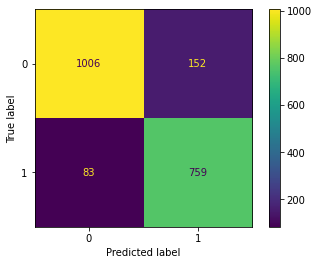

In [ ]:
warnings.filterwarnings('ignore')
def classify_hate(model, vocabulary_size, X_train_txt, y_train, confusion_matrix = False, tree1 = False, save_model=False, loss = 'log', alpha=0.6877):
    is_partial = False
    cv = CountVectorizer(max_features = vocabulary_size)
    train = [' '.join(x) for x in X_train_txt]
    X = cv.fit_transform(train).toarray()
    y = list(y_train[0])

    if model == 'KNN':
        classifier = KNeighborsClassifier(n_neighbors = 5)
    elif model == "SGDC":
        classifier = SGDClassifier(loss=loss)
        is_partial = True
    elif model == "MultinomialNB":
        classifier = MultinomialNB()
        is_partial = True
    elif model == "DTC":
        classifier = DecisionTreeClassifier()
    elif model == "RF":
        classifier = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state = 0)
    if is_partial:
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
        sss.get_n_splits(X, y_train)
        y_train_1 = y_train.copy().to_numpy().astype(int)
        i = 0
        for train_index, test_index in sss.split(X, y_train_1):
            X_train_s, X_val_s = X[train_index], X[test_index]
            y_train_s, y_val_s= y_train_1[train_index], y_train_1[test_index]
            if i==0:
                classifier.partial_fit(X_train_s, y_train_s, classes = [0,1])
            else:
                classifier.partial_fit(X_train_s, y_train_s)
        X_test,y_test = X_val_s,y_val_s
        pred = classifier.predict(X_val_s)
        acc_score = accuracy_score(y_test, pred)
        f1score = f1_score(y_val_s, pred)
    else:               
        X_train, X_test, y_train_1, y_test = train_test_split(
                X, y, test_size = 0.25, random_state = 0)
        classifier.fit(X_train, y_train_1)
        pred = classifier.predict(X_test)
        acc_score = accuracy_score(y_test, pred)
        # print(set(y_test),set(pred))
        f1score = f1_score(y_test, pred, pos_label='1')
        # print('Our magnificent f1score: ',f1score)
    if confusion_matrix == True:
        plot_confusion_matrix(classifier, X_test, y_test)
    if tree1 == True:
        # print("Plotting Decision Tree...")
        text_representation = tree.export_text(classifier, feature_names = list(cv.get_feature_names_out()))
        # print(text_representation)
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(classifier, feature_names = list(cv.get_feature_names_out()), class_names=['non-hatespeech', 'hatespeech'])
        plt.savefig("tree.svg", format="svg")

    if save_model == True:
        filename = '/work/twitter-nlp/data/pickle/models/hatespeech_model_MultinomialNB2.sav'
        pickling(classifier,filename)

    return f1score,acc_score

classify_hate("MultinomialNB", vocabulary_size_hate, X_train_txt, y_train, confusion_matrix = True, save_model=True)

In [ ]:
# warnings.filterwarnings('ignore')
# def classify_hate(model, confusion_matrix = False, tree1 = False, loss = 'log', alpha=0.6877):
#     is_partial = False
#     global y_train

#     if model == 'KNN':
#         classifier = KNeighborsClassifier(n_neighbors = 5)
#     elif model == "SGDC":
#         classifier = SGDClassifier(loss=loss)
#         is_partial = True
#     elif model == "MultinomialNB":
#         classifier = MultinomialNB()
#         is_partial = True
#     elif model == "DTC":
#         classifier = DecisionTreeClassifier()
#     elif model == "RF":
#         classifier = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state = 0)
#     if is_partial:
#         acc_score,f1score,X_test,y_test = partial_fitting_hate(classifier)
#         # print(acc_score, '\n', f1score)
#     else:               
#         cv = CountVectorizer(max_features = 209923)
#         train = [' '.join(x) for x in X_train_txt]
#         X = cv.fit_transform(train).toarray()
#         y = list(y_train[0])
#         X_train, X_test, y_train_1, y_test = train_test_split(
#                 X, y, test_size = 0.25, random_state = 0)
#         classifier.fit(X_train, y_train_1)
#         pred = classifier.predict(X_test)
#         acc_score = accuracy_score(y_test, pred)
#         # print(set(y_test),set(pred))
#         f1score = f1_score(y_test, pred, pos_label='1')
#         # print('Our magnificent f1score: ',f1score)
#     if confusion_matrix == True:
#         plot_confusion_matrix(classifier, X_test, y_test)
#     if tree1 == True:
#         # print("Plotting Decision Tree...")
#         text_representation = tree.export_text(classifier, feature_names = list(cv.get_feature_names_out()))
#         # print(text_representation)
#         fig = plt.figure(figsize=(25,20))
#         _ = tree.plot_tree(classifier, feature_names = list(cv.get_feature_names_out()), class_names=['non-hatespeech', 'hatespeech'])
#         plt.savefig("tree.svg", format="svg")

#     # filename = "/work/data/pickle/models/hate/dtc.sav"
#     # pickle.dump(classifier, open(filename, 'wb'))

#     return f1score,acc_score

# classify_hate("MultinomialNB", confusion_matrix = False)

In [ ]:
#basically the one above but now only training and saving the model

def train_model(model, vocabulary_size, X_train_txt, y_train):
    
    
    is_partial=False
    train = [' '.join(x) for x in X_train_txt]
    cv = CountVectorizer(max_features = vocabulary_size)
    X = cv.fit_transform(train).toarray()


    if model == 'KNN':
        classifier = KNeighborsClassifier(n_neighbors = 5)
    elif model == "SGDC":
        classifier = SGDClassifier(loss=loss)
        is_partial = True
    elif model == "MultinomialNB":
        classifier = MultinomialNB()
        is_partial = True
    elif model == "DTC":
        classifier = DecisionTreeClassifier()
    elif model == "RF":
        classifier = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state = 0)
    if is_partial:
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
        sss.get_n_splits(X, y_train)
        y_train_1 = y_train.copy().to_numpy().astype(int)
        i = 0
        for train_index, test_index in sss.split(X, y_train_1):
            X_train_s, X_val_s = X[train_index], X[test_index]
            y_train_s, y_val_s= y_train_1[train_index], y_train_1[test_index]
            if i==0:
                classifier.partial_fit(X_train_s, y_train_s, classes = [0,1])
            else:
                classifier.partial_fit(X_train_s, y_train_s)
    else:
        X_train, X_test, y_train_1, y_test = train_test_split(
            X, y_train, test_size = 0.25, random_state = 0)
        classifier.fit(X_train, y_train_1)
        pred = classifier.predict(X_test)

    # filename = '/work/twitter-nlp/data/pickle/models/hatespeech_model_MultinomialNB.sav'
    # pickling(classifier,filename)
    return classifier

In [ ]:
print(type(y_train),vocabulary_size_hate)
train_model("MultinomialNB", vocabulary_size_hate, X_train_txt, y_train)

<class 'pandas.core.frame.DataFrame'> 209923


MultinomialNB()

To better understand the results, we show the ratio of hatespeech, and not hatespeech below. <br/>

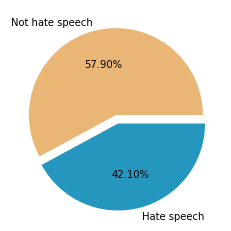

In [ ]:
plt.pie(collections.Counter(list(y_train[0])).values(), labels=['Not hate speech','Hate speech'],colors=['#eab676','#2596be'],explode=(0, 0.1), autopct = lambda p:f'{p:.2f}%');

Based on this we deduced that our results were acceptable. 

In [ ]:
models = ["KNN", "SGDC", 'MultinomialNB','DTC', 'RF']
li = {}

for model in models:
    li.setdefault(model, classify_hate(model, vocabulary_size_hate, X_train_txt, y_train))

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
li

NameError: name 'li' is not defined

# Hate speech functions

#### Classifiers that have partial_fit() which we will be using
- sklearn.naive_bayes.MultinomialNB
- sklearn.naive_bayes.BernoulliNB sklearn.linear_model.Perceptron
- sklearn.linear_model.SGDClassifier
- sklearn.linear_model.PassiveAggressiveClassifier

Testing different types of loss for the SGDC classifier on the hatespeech dataset

In [ ]:
# losses = ['hinge','modified_huber','log','squared_hinge','perceptron','squared_error','huber','epsilon_insensitive','squared_epsilon_insensitive']
# scores = {s:0 for s in losses}
# for _ in range(10):
#     for loss in losses:
#         print(loss)
#         scores[loss]+=float(classify_hate('SGDC',loss=loss)[0])/10
# scores
open_jar('/work/twitter-nlp/data/pickle/models/hate/loss_scores.pkl')

hinge


NameError: name 'classify_hate' is not defined

Explain this TODO

In [ ]:
# alpha_scores = {max([0.0001 * s * s,0.0001]):0 for s in range(0,100,10)}


# for _ in range(10):
#     for i in range(0,100,10):
#         coef = max([0.0001 * i * i,0.0001]) 
#         alpha_scores[coef]+=float(classify_hate('SGDC',alpha = coef)[0])/10

In [ ]:
#pickling(scores,'/work/twitter-nlp/data/pickle/models/hate/loss_scores.pkl')
alpha_scores = open_jar('/work/twitter-nlp/data/pickle/models/hate/alpha_scores.pkl')
alpha_scores

{0.6: 0.7226649458214888,
 0.61: 0.7513427563325703,
 0.62: 0.7326090594945454,
 0.63: 0.7457790143602933,
 0.64: 0.7376082590657582,
 0.65: 0.717346505113557,
 0.66: 0.7467129694744707,
 0.67: 0.7483145916929301,
 0.68: 0.7582834509352506,
 0.69: 0.7432255177317246}

Printing final alpha scores TODO

In [ ]:
alpha_scores_4 = open_jar('/work/twitter-nlp/data/pickle/models/hate/alpha_scores_3.pkl')
alpha_scores_4
#pickling(alpha_scores_2,'/work/twitter-nlp/data/pickle/models/hate/alpha_scores.pkl')
#pickling(alpha_scores_3,'/work/twitter-nlp/data/pickle/models/hate/alpha_scores_2.pkl')
#pickling(alpha_scores_4, '/work/twitter-nlp/data/pickle/models/hate/alpha_scores_3.pkl')

{0.687: 0.7466837827410123,
 0.6871: 0.7321857661693683,
 0.6872: 0.7346982418843386,
 0.6873: 0.7509777646725955,
 0.6874: 0.7356000977143823,
 0.6875: 0.7416393100901192,
 0.6876: 0.7492228693383467,
 0.6877: 0.7553777802640925,
 0.6878: 0.748947046902999,
 0.6879: 0.7502418991606316}

## Emoji Prediction Model Training:

In [ ]:
five_split_txt_emoji = np.array_split(X_train_txt_emoji, 5)
len(five_split_txt_emoji[0])

10000

In [ ]:
five_split_labels_emoji = np.array_split(y_train_emoji,5)
len(five_split_labels_emoji[0])

10000

Showing ratio of labels in our dataset:

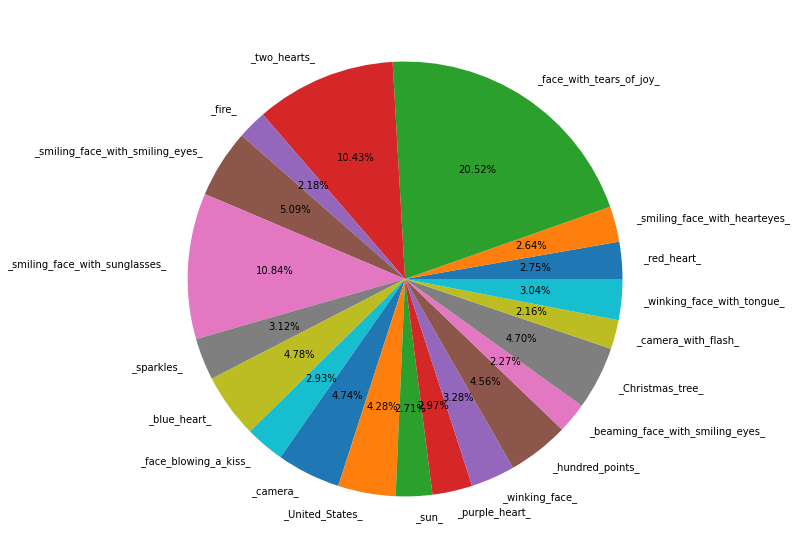

In [ ]:
plt.figure(figsize=(10, 10))
plt.pie(collections.Counter(list(y_train_emoji[0])).values(), labels=list(emoji_classes[2]), autopct = lambda p:f'{p:.2f}%');


In [ ]:
lst = [x for x in list(emoji_classes[2])]

Training based on different models, all in one function, and plotting confusion matrix.

In [ ]:
#helper function to classify emojis, using the stratified shuffle split
def partial_fitting_emoji(classifier):
    global y_train_emoji
    cv = CountVectorizer(max_features = 5000)
    # X_train_emoji = cv.fit_transform([' '.join(s) for s in X_train_txt_emoji]).toarray()
    i = 0
    for X, y in zip(five_split_txt_emoji,five_split_labels_emoji):
        X_train_emoji = cv.fit_transform([' '.join(s) for s in X])
        X_train, X_test, y_train, y_test = train_test_split(X_train_emoji, y, test_size = 0.25, random_state = 0)
       # print(f'X_train {X_train}, X_test {X_test}, y_train {y_train}, y_test {y_test}')
        a = list(np.unique(y_test))
        a.sort()
        #print(f'y_test:\n {a}\n\n')
        if i==0:
            classifier.partial_fit(X_train, y_train, classes = list(emoji_classes[0]))#Get classes for emoji
        else:
            classifier.partial_fit(X_train, y_train)
    
        pred = classifier.predict(X_test)

        scores = accuracy_score(y_test, pred)
        i += 1
    return scores, X_test, y_test, pred

0.2224 

{0: 0.34375, 1: 0.2364672364672365, 2: 0.29431438127090304, 3: 0.05982905982905983, 4: 0.22950819672131145, 5: 0.06896551724137931, 6: 0.102803738317757, 7: 0.11627906976744186, 8: 0.03809523809523809, 9: 0.08, 10: 0.11956521739130434, 11: 0.3111111111111111, 12: 0.22429906542056074, 13: 0.0, 14: 0.01941747572815534, 15: 0.0, 16: 0.07407407407407407, 17: 0.6766917293233082, 18: 0.08695652173913043, 19: 0.0303030303030303}


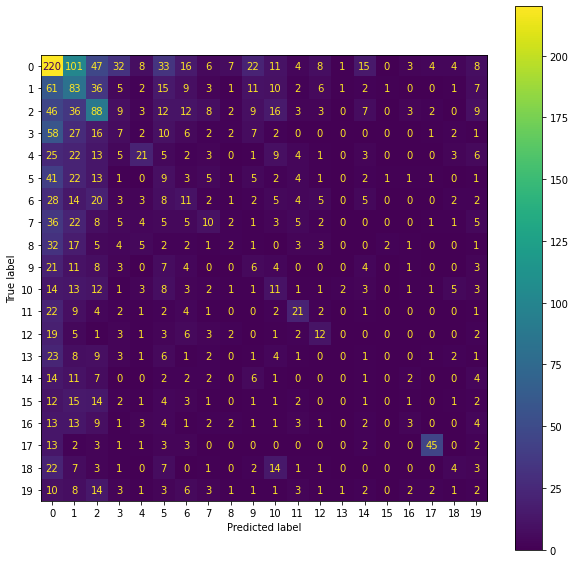

In [ ]:
warnings.filterwarnings('ignore')

def classify_emoji(model, confusion_matrix = False, tree1 = False):
    is_partial = False
    global y_train
    if model == 'KNN':
        classifier = KNeighborsClassifier(n_neighbors = 5)
    elif model == "SGDC":
        classifier = SGDClassifier(loss='log')
        is_partial = True
    elif model == "MultinomialNB":
        classifier = MultinomialNB()
        is_partial = True
    elif model == "DTC":
        classifier = DecisionTreeClassifier()
    elif model == 'GaussianNB':
        classifier = GaussianNB()
        is_partial = True
    if is_partial:
        acc_score, X_test,y_test, pred =  partial_fitting_emoji(classifier)
        f1score = f1_score(y_test, pred, average=None)
    else:
        cv = CountVectorizer(max_features = 5000)
        scores = []
        X, y = X_train_txt_emoji, y_train_emoji
        X_train_emoji = cv.fit_transform([' '.join(s) for s in X])
        X_train, X_test, y_train, y_test = train_test_split(X_train_emoji, y, test_size = 0.25, random_state = 0)
        classifier.fit(X_train, y_train)
        pred = classifier.predict(X_test)
        f1score = f1_score(y_test,pred)
        acc_score = accuracy_score(y_test, pred)
        scores.append(acc_score)
    if confusion_matrix == True:
        _, ax = plt.subplots(figsize=(10,10))
        plot_confusion_matrix(classifier, X_test, y_test, ax = ax)
    if tree1 == True:
        print("Plotting Decision Tree...")
        text_representation = tree.export_text(classifier, feature_names = list(cv.get_feature_names_out()))
        print(text_representation)
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(classifier, feature_names = list(cv.get_feature_names_out()), class_names=emoji_classes[1])
        plt.savefig("tree.svg", format="svg")
    return acc_score, X_test, pred, f1score
    

acc_score,X_test,pred, f1score = classify_emoji("SGDC", confusion_matrix = True)

#pred_df = pd.DataFrame(pred)
#pred_df
print(acc_score,'\n')
keys = [val for val in range(0,20)]
f1_lst = [x for x in f1score]
print(dict(zip(keys,f1_lst)))

# for i in range(5):
#     indx = random.randint(0,len(pred))
#     print('Our shitty predictions _________________')
#     print(X_test[indx],pred[indx])

TODO for this notebook:
- [ ] clean up different text blocks, explain what our code is doing (see todo/comments)
- [ ] implement porter stemmer for both datasets
- [ ] work on the extraction text transformer
- [ ] evaluate different classifiers on emoji ds
- [ ] run additional tests on emoji ds
- [ ] report results for emoji ds
- [ ] clean up hatespeech ds results

- [ ] Evaluate your different classifiers on the validation set and report relevant evaluation metrics (accuracy, precision/recall/F-score).

- [ ] Then run additional experiments trying to improve your initial scores by any means you can think of. Try out at least 4 different methods.

Additional preprocessing options:
- [ ] n-gram features, lowercasing, stop word lists (see options to `sklearn.feature_extraction.text.CountVectorizer)`
- [ ] `Counttransformations(sklearn.feature_extraction.text.TfIdfTransformer)`
- [ ] `Theclassificationloss(lossparametertoSGDClassifier)`
- [ ] The regularisation strength (alpha parameter to `SGDClassifier` – try varying it in exponentially spaced steps)
- [ ] Different classifiers (e.g.,`sklearn.ensemble.RandomForestClassifieror sklearn.naive_bayes.MultinomialNB`)
- [ ] Anything else discussed during the lessons, or implemented in scikit-learn.

- [ ] For the systems that achieves the highest accuracy on the validation set, run the evaluation on the test set and report your results.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bf1f20fb-a6c0-4ea2-8567-a5a41eea1d8a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>